# Analysis of Locomotion rhythms using Pynapple

##### 1. Clean the data (background subtraction, bandpass filter, normalization)
##### 2. Find max frequency and determine if it matches with lumbar nerve frequency (mean PSD)
##### 3. Determine synchronicity with lumbar nerve (Correlation)
##### 4. Determine phase locking value ???

# Import

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.fft import fft, fft2, ifft, ifft2, fftfreq
from scipy import signal
from scipy.signal import welch
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
import pynapple as nap

# Read CSV file. Define T and ROIs.

In [14]:
data = pd.read_csv("/Users/araya/Sync/LAB SG/DBX1 Analysis/AU20250716-xyt3.csv", 
                   header=None,
                   na_values=[' '])

data = data.fillna(0)
data_float = np.array(data)

In [3]:
# Define time using number of samples (N) and sample spacing (T)
N = len(data)                       # Experimental parameter: 400 frames
T = 0.277                           # Experimental parameter: 277 ms per frame
fs = 1/T                            # fs = sampling rate in Hz
#time = np.arange(0, N*T, T)        # Generate time series from 0 to N*T seconds at sampling interval T
                                    # Don't need if there is already a time column on CSV file

In [4]:
# Define ROIs
red_end = 16
green_end = 27
background_roi = 28

In [5]:
# Extract time column and data columns
time = data.iloc[:, 0].values                      # time: first column index 0
signals = data.iloc[:, 1:31].values                # This include index 1 to 30 of data array (stop at index 31) 2 nerve and 28 ROI columns
background = data.iloc[:, 30].values   

# Background subtraction
##### Background subtraction is a general pre-processing of data.
##### Spectral subtraction (in PSD freqency domain) is also a form of background removal.
##### Nonetheless, a preceding step might be necessary to improve the accuracy of the spectral subtraction or PSD estimate. 

In [6]:
# Define background
bg_index = signals.shape[1] - 1           # return index 29 (roi #28, background roi)
last_index = signals.shape[1]             # return 30 columns from index 0 to 29 (2 nerves + 28 rois)

df = pd.DataFrame(signals)

#print("Original DataFrame:")
#print(df)

# Specify the columns to subtract from
target_columns = list(range(2, last_index))     # indices 0 and 1 are the 2 nerve signals - no subtracted by image background ROI

# Subtract background ROI from the target columns
for col in target_columns:
    df[col] = df[col] - df[bg_index]
    
#print("\nDataFrame after subtraction:")
#print(df)

# Normalization to min/max

In [17]:
# df from above is a dataframe of nerve signals and background subtracted ROI signals

# Apply Min-Max Normalization to each column
df_norm = (df - df.min()) / (df.max() - df.min())

df_norm = df_norm.fillna(0)

# Convert dataframe to np.array
data_norm = df_norm.to_numpy()



# Create TsdFrame

In [18]:
# Naming columns -- Doesn't seem to work
#rois = [f"ROI{i}" for i in range(1, data.shape[1] + 1)]
#columns = ["nerve1", "nerve2", f"ROI{i}" for i in range(1, data.shape[1] + 1)]

# Create the TsdFrame
#tsdframe = nap.TsdFrame(t=time, d=data, columns=["nerve1", "nerve2", rois])
#tsdframe = nap.TsdFrame(t=time, d=data, columns=columns)

tsdframe = nap.TsdFrame(t=time, d=data_norm)

print(tsdframe)

Time (s)    0        1        2        3        4        ...
----------  -------  -------  -------  -------  -------  -----
0.277       0.71716  0.33762  0.45175  0.09817  0.82333  ...
0.554       0.44809  0.60986  0.57598  0.22624  0.76525  ...
0.831       0.39936  0.69025  0.50822  0.16339  0.72666  ...
1.108       0.3697   0.89603  0.2173   0.27885  0.75722  ...
1.385       0.40678  0.79528  0.48413  0.24162  0.78391  ...
1.662       0.59322  0.7224   0.26961  0.08359  0.72078  ...
1.939       0.87606  0.56699  0.48408  0.21527  0.4698   ...
...         ...      ...      ...      ...      ...      ...
109.138     0.67479  0.38692  0.90542  0.48796  0.40404  ...
109.415     0.73305  0.33548  0.82252  0.48638  0.41847  ...
109.692     0.52225  0.39764  0.66898  0.42529  0.56687  ...
109.969     0.37924  0.55734  0.75447  0.38122  0.42162  ...
110.246     0.28919  0.75241  0.99333  0.43115  0.50992  ...
110.523     0.20021  0.72883  1.0      0.48632  0.4559   ...
110.8       0.20021  0

# Defining columns in Tsdframe

In [19]:
nerve1 = tsdframe.loc[0]
nerve2 = tsdframe.loc[1]

# print(nerve1)

#plt.plot(nerve1)
#plt.plot(nerve2)

# Bandpass filter

Time (s)    0         1         2         3         4         ...
----------  --------  --------  --------  --------  --------  -----
0.277       -0.00875  0.00499   -0.00627  -0.02689  -0.05892  ...
0.554       -0.23277  0.22961   0.09833   0.03626   -0.13137  ...
0.831       -0.34007  0.40089   0.01266   0.09377   -0.12322  ...
1.108       -0.34535  0.48808   -0.13407  0.099     -0.07414  ...
1.385       -0.26917  0.46694   -0.14475  0.03785   -0.09225  ...
1.662       -0.08565  0.33932   -0.06513  -0.00702  -0.16285  ...
1.939       0.1395    0.17861   -0.06168  0.0097    -0.19872  ...
...         ...       ...       ...       ...       ...       ...
109.138     0.49058   -0.36645  -0.02539  0.12394   -0.10083  ...
109.415     0.47318   -0.40735  -0.1348   0.10366   -0.19833  ...
109.692     0.37264   -0.34973  -0.26129  0.02316   -0.13485  ...
109.969     0.21777   -0.19514  -0.21065  0.00122   -0.1017   ...
110.246     0.10875   -0.05342  -0.03994  0.05798   -0.14354  ...
110.523 

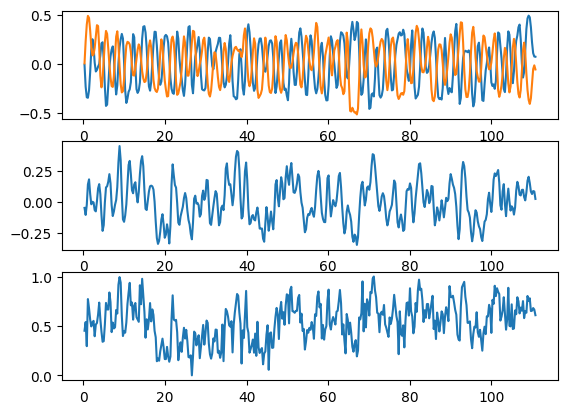

In [24]:
# filtering certain frequencies
clean_tsdframe = nap.apply_bandpass_filter(tsdframe, (0.0277, 1), fs = 1/T, mode='butter') 
print(clean_tsdframe)

# Filter between 0.01 and 1 Hz at sampling rate 1/T Hz
# Digital filter critical frequencies must be 0 < Wn < fs/2

# Define ROI to plot
roi_index = 26

fig, axs = plt.subplots(3,1)     # (3,1) set plot axes to 3 rows and 1 column
plt.sca(axs[0])                  # .sca set current axis
plt.plot(clean_tsdframe.loc[0])
plt.plot(clean_tsdframe.loc[1])

plt.sca(axs[1])  
plt.plot(clean_tsdframe.loc[roi_index])
plt.sca(axs[2])  
plt.plot(tsdframe.loc[roi_index])

# Power Spectral Density

##### Normalize the signals before doing PSD because signal amplitude does affect PSD results, i.e. power is related to the square of the amplitude.

# PSD of raw signals

Text(0, 0.5, 'Power/Frequency')

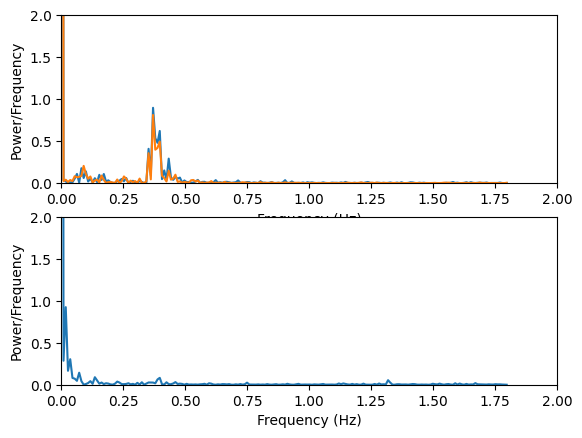

In [25]:
roi = tsdframe.loc[20]

psd_nerve1 = nap.compute_power_spectral_density(nerve1, fs=1/T)
psd_nerve2 = nap.compute_power_spectral_density(nerve2, fs=1/T)
psd_roi = nap.compute_power_spectral_density(roi, fs=1/T)

fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(psd_nerve1)
plt.plot(psd_nerve2)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(psd_roi)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")


# PSD of filtered signals

Text(0, 0.5, 'Power/Frequency')

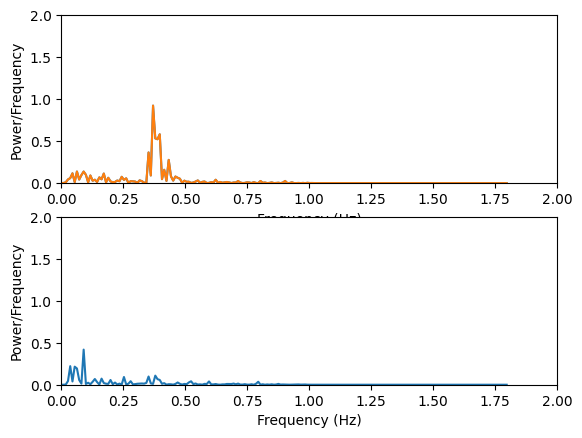

In [30]:
nerve1_filtered = clean_tsdframe.loc[0]
nerve2_filtered = clean_tsdframe.loc[1]
roi_filtered = clean_tsdframe.loc[28]

psd_nerve1_filtered = nap.compute_power_spectral_density(nerve1_filtered, fs=1/T)
psd_nerve2_filtered = nap.compute_power_spectral_density(nerve1_filtered, fs=1/T)
psd_roi_filtered = nap.compute_power_spectral_density(roi_filtered, fs=1/T)

fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(psd_nerve1_filtered)
plt.plot(psd_nerve2_filtered)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(psd_roi_filtered)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")


# Mean PSD of filtered signals - Smooth out the noise of PSD

In [63]:
# Define ROI
roi_filtered = clean_tsdframe.loc[28]

mean_psd_nerve1_filtered = nap.compute_mean_power_spectral_density(nerve1_filtered, interval_size=100*T, fs=1/T)
mean_psd_nerve2_filtered = nap.compute_mean_power_spectral_density(nerve2_filtered, interval_size=100*T, fs=1/T)
mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(roi_filtered, interval_size=100*T, fs=1/T)

# Return mean power spectral density of the input signal. 
# Indexes are frequencies and values are powers/frequency.
# Return pandas.DataFrame

mean_psd_roi = pd.DataFrame()
filtered_roi = list(range(2, last_index))                # specify indices of all ROIs

for roi in filtered_roi:
    mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(clean_tsdframe.loc[roi], interval_size=100*T, fs=1/T)
    mean_psd_roi[roi] = mean_psd_roi_filtered

#print(mean_psd_roi)
    
# write DataFrame to an excel sheet 
# mean_psd_roi.to_excel('mean_psd_roi.xlsx')

Text(0, 0.5, 'Power/Frequency')

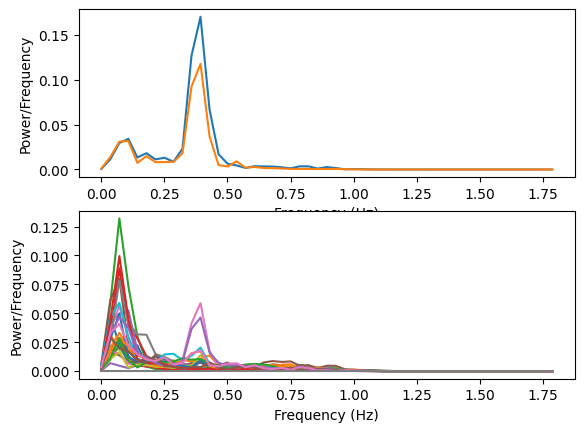

In [62]:
# Plot
fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(mean_psd_nerve1_filtered)
plt.plot(mean_psd_nerve2_filtered)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(mean_psd_roi)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

In [ ]:
# If pull out only the loco frequency, will the correlation get better?
# What's the slow frequency?

# ** Below is still work in progress 

# Spectral Subtraction - Subtract PSD of background from PSD of signals

# Fast Fourier Transform

In [75]:
# compute the fast fourier transform (FFT)

dt = T                                                      # no. of frames / duration of recording (frame rate)
n = len(time)
fhat = np.fft.fft(clean_tsdframe.to_numpy(), n)             # compute the FFT
PSD = fhat * np.conj(fhat) / n                              # power spectrum (power per frequency)
freq = (1/(dt * n)) * np.arange(n)                          # create x-axis of frequencies
#L = np.arange(1, np.floor(n/2), dtype = 'int')             # only plot the first half

# Use PSD to filter out noise

/Users/araya/miniforge3/envs/pynapple/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/araya/miniforge3/envs/pynapple/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


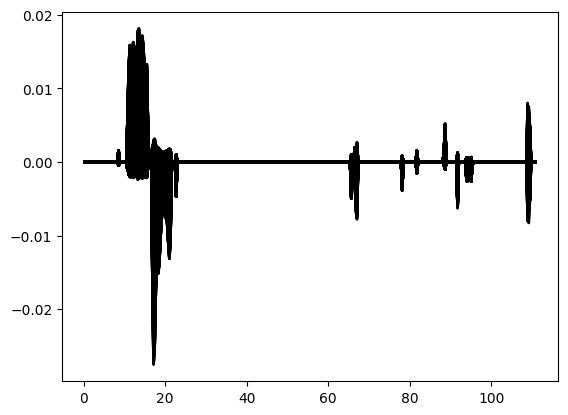

In [65]:
indices = PSD > 0.01                               # find all freqs with large power
PSDclean = PSD * indices                           # find out all others
fhat = indices * fhat                              # zero out small fourier coeff. in Y
fhat_scaled = 0.1 * fhat
ffilt = np.fft.ifft(fhat_scaled)                   # inverse FFT for filtered time signal

plt.plot(time, ffilt, color = 'k', linewidth = 2, label = 'filtered')
plt.show()


# Frequency at the maximum power (peak frequency) 

In [36]:
# Initialize an empty list
signal_list = []
max_power_index_list = []
frequency_at_max_power_list = []

for i in range(0, last_index):
    signal = clean_tsdframe.loc[i]
    mean_psd = nap.compute_mean_power_spectral_density(signal, interval_size=100*T, fs=1/T)
    max_power_index = np.argmax(mean_psd)                            # get index of maximum PSD
    frequency_at_max_power = mean_psd.index[max_power_index]         # get corresponding frequency
    signal_list.append(i)
    max_power_index_list.append(max_power_index)                     # loop and append data to list
    frequency_at_max_power_list.append(frequency_at_max_power)       # loop and append data to list
   
# Convert the list to DataFrame 
max_psd = {'Signal': signal_list, 'Index of max power': max_power_index_list, 'Freq at max power': frequency_at_max_power_list}
max_psd_df = pd.DataFrame(max_psd)
print(max_psd_df)

    Signal  Index of max power  Freq at max power
0        0                  11           0.393180
1        1                  11           0.393180
2        2                   2           0.071487
3        3                   1           0.035744
4        4                   2           0.071487
5        5                   2           0.071487
6        6                   3           0.107231
7        7                   2           0.071487
8        8                   2           0.071487
9        9                   2           0.071487
10      10                   1           0.035744
11      11                   2           0.071487
12      12                   1           0.035744
13      13                   2           0.071487
14      14                   2           0.071487
15      15                   2           0.071487
16      16                   8           0.285949
17      17                   1           0.035744
18      18                  11           0.393180


ROIs with max frequency = loco frequency: [18]
ROIs with max frequency between 50%-100% of loco frequency: [16]
ROIs with max frequency between 0.2 and 50% of loco frequency: [16]
ROIs with max frequency between 0 and 0.2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
ROIs with max frequency > loco frequency: []


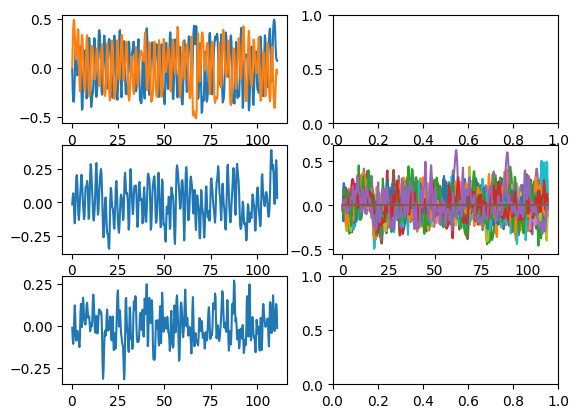

In [94]:
equal_list = []
list1 = []
list2 = []
list3 = []
list4 = []

fig, axs = plt.subplots(3,2) 
plt.sca(axs[0, 0])
plt.plot(clean_tsdframe.loc[0])
plt.plot(clean_tsdframe.loc[1])

for i in range(2, last_index):
    if max_psd_df.iloc[i, 2] == max_psd_df.iloc[0, 2]:
        equal_list.append(i)
        plt.sca(axs[1, 0])    
        plt.plot(clean_tsdframe.loc[i], label=f"{i}")
        
    if 0.6 <= max_psd_df.iloc[i, 2] < 0.8:
        list1.append(i)
        plt.sca(axs[2, 0])    
        plt.plot(clean_tsdframe.loc[i], label=f"{i}")
        
    if 0.4 <= max_psd_df.iloc[i, 2] < 0.6:
        list2.append(i)
        plt.sca(axs[0, 1])    
        plt.plot(clean_tsdframe.loc[i], label=f"{i}")

    if 0.2 <= max_psd_df.iloc[i, 2] < 0.4:
        list3.append(i)
        plt.sca(axs[1, 1])    
        plt.plot(clean_tsdframe.loc[i], label=f"{i}")
        
     if 0 <= max_psd_df.iloc[i, 2] < 0.2:
        list4.append(i)
        plt.sca(axs[2, 1])    
        plt.plot(clean_tsdframe.loc[i], label=f"{i}")

print(f"ROIs with max frequency = loco frequency: {equal_list} at max_psd_df.iloc[0, 2]")
print(f"ROIs with max frequency between 0.6 and 0.8 Hz: {list1}")
print(f"ROIs with max frequency between 0.4 and 0.6 Hz: {list1}")
print(f"ROIs with max frequency between 0.2 and 0.4 Hz: {list1}")
print(f"ROIs with max frequency > loco frequency: {list4}")

 # Correlation

       0      1      2      3      4      5      6      7      8      9   ...  \
0   1.000 -0.820 -0.205 -0.079 -0.108 -0.019 -0.063 -0.061 -0.023  0.014  ...   
1  -0.820  1.000  0.108 -0.011  0.121  0.045  0.053  0.147  0.044  0.016  ...   
2  -0.205  0.108  1.000  0.136  0.260  0.012 -0.073  0.253  0.137  0.233  ...   
3  -0.079 -0.011  0.136  1.000  0.027 -0.034  0.368  0.060  0.185  0.222  ...   
4  -0.108  0.121  0.260  0.027  1.000  0.137  0.082  0.441  0.091  0.155  ...   
5  -0.019  0.045  0.012 -0.034  0.137  1.000 -0.014  0.190  0.145  0.281  ...   
6  -0.063  0.053 -0.073  0.368  0.082 -0.014  1.000  0.011  0.149  0.173  ...   
7  -0.061  0.147  0.253  0.060  0.441  0.190  0.011  1.000  0.216  0.169  ...   
8  -0.023  0.044  0.137  0.185  0.091  0.145  0.149  0.216  1.000  0.334  ...   
9   0.014  0.016  0.233  0.222  0.155  0.281  0.173  0.169  0.334  1.000  ...   
10 -0.157  0.168  0.389  0.158  0.223  0.022 -0.029  0.281  0.306  0.212  ...   
11  0.020  0.010  0.269  0.2

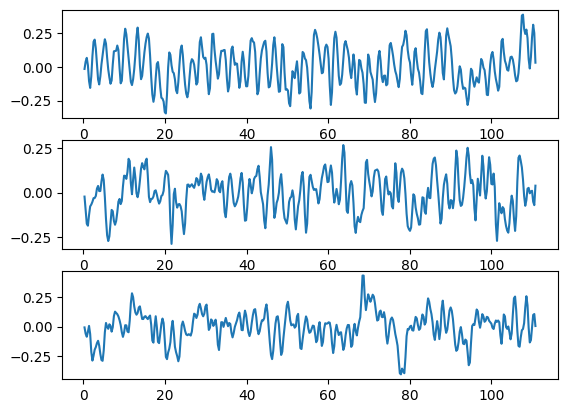

In [41]:
# Convert TsdFrame object to pandas.DataFrame object
clean_df = clean_tsdframe.as_dataframe()

# Comput correlation matrix
correlation_matrix = clean_df.corr().round(3)

print(correlation_matrix)

fig, axs = plt.subplots(3,1) 
plt.sca(axs[0])
plt.plot(clean_tsdframe.loc[18])
plt.sca(axs[1])
plt.plot(clean_tsdframe.loc[20])
plt.sca(axs[2])
plt.plot(clean_tsdframe.loc[22])

# Thresholding

In [ ]:
bg_roi = tsdframe.loc[28]
roi1 = tsdframe.loc[3]
roi1_bgsubtract = roi1 - bg_roi

#tsd = tsdframe.threshold(0.5)